In [2]:
# When using Colab, make sure you run this instruction beforehand
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 78.1 MB/s eta 0:00:00


**Problem 1: extended formulation for fixed charge network flow problem**

Consider the network topology given by the graph $G = (V,A)$ in the figure, where $V =
\{s, t, u,w\}$. Each node represents a router of the network, and each arc $(i, j \in A$ with $i, j \in V$ represents a link. The numbers associated to each arc $(i, j)$ correspond to $u_{ij},f_{ij}$ , where $u_{ij} > 0$ is the bandwidth (arc capacity) in Mbps and $f_{ij} > 0$ is the fixed cost of using the arc.



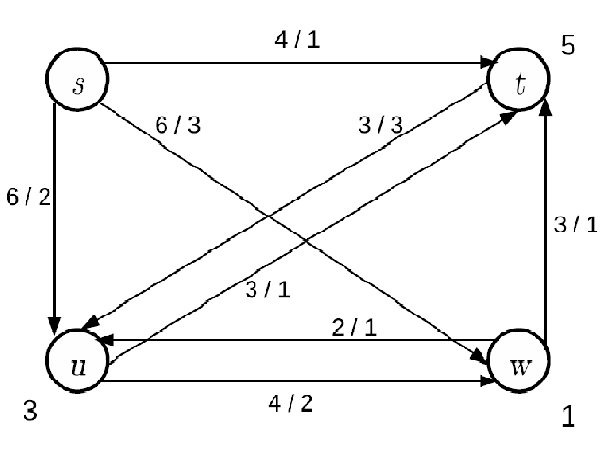

There is a single source node s and a subset $K \subseteq V \setminus \{s\}$ of destinations (terminals). Next
to each destination node $i \in K$ we report its flow (bandwidth) demand $b_i$. For the destination
nodes $i \in K$ we assume $b_i > 0$. For the source node $s, b_s$ represents the total availability, that
we assume equivalent to the sum of the demands of all nodes $i \in K$, that is, $b_s = \sum_{i \in K}b_i$.


The aim is to determine the feasible minimum cost flow that satisfies the requirements of all destinations $i \in K$.
1. Write in Python the natural MILP formulation for fixed charge network 
ow problem described in class.
2. Solve its linear relaxation. Is the optimal solution integer?


**Sets**


*   $V$: nodes
*   $A \subseteq V \times V$: arcs
*   $T \subseteq V$: destination nodes 


**Parameters**

* $s \in V\setminus T$: source node
*    $u_{ij}$: capacity of the arc $(i,j)$, with $(i,j) \in A$
*    $c_{ij}$: cost of the arc $(i,j)$, with $(i,j) \in A$
*    $b_i$: flow requirements in node $i$, with $b_i=\left \{ \begin{matrix} >0 & i \in T\\ <0 & i = s \\ 0 & otherwise  \end{matrix} \right .$


**Decision variables**

* $x_{ij}$: flow sent over the arc $(i,j)$, with $(i,j) \in E$
* $y_{ij}$: binary variable indicating if $(i,j) \in E$ is used


**Model**

For each node $i \in V$, let $\delta^{+}\left (i \right ) = \left \{ j \in V:\left ( i,j\right ) \in A\right\}$, $\delta^{-}\left (i \right ) = \left \{ j \in V:\left ( j,i\right ) \in A\right\}$. 


\begin{eqnarray*}
\min \quad & \sum_{(i,j)\in E}c_{ij}y_{ij} && \mbox{(value)}\\
\mbox{s.t.} \quad &&& \\
& \sum_{j \in \delta^{-}(i)} x_{ji} - \sum_{j \in \delta^{+}(i)} x_{ij} = b_i %\left \{ \begin{matrix}  & i = s\\ -\phi & i\in T \\ 0 & h \in V \backslash \{s,t\}  \end{matrix} \right . 
\quad & i \in V & \mbox{(balance)}\\
& x_{ij} \leq u_{ij}y_{ij} \quad & (i,j) \in A \quad & \mbox{(capacity)}\\
& x_{ij} \geq 0 & (i,j) \in A \quad & \mbox{(nonnegative var.)}\\
& y_{ij} \in \{0,1\} & (i,j) \in A \quad & \mbox{(binary var.)} 
\end{eqnarray*}

In [3]:
import mip
#import string
import ast
import pandas as pd # to handle the data of the problem
from itertools import chain, combinations # for the computation of the powerset
from mip import BINARY
import numpy as np
import time

In [34]:
# SET & PARAMETER DEFINITION
source = 's'
b = pd.read_csv('b_4nodes.csv',sep=';')
b.set_index('index', inplace = True)
b = b.to_dict()['b']

b[source] = - sum(list(b.values()))
V = list(b.keys())

fu = pd.read_csv('f_u4nodes.csv',sep=';')
fu['index'] = fu['index'].apply(ast.literal_eval)
fu.set_index('index', inplace = True)

f = fu.to_dict()['f']
u = fu.to_dict()['u']



# Auxiliary set A
A = list(f.keys())

In [35]:
model = mip.Model()

In [36]:
x = {edge: model.add_var(lb=0,name ='x_'+edge[0]+edge[1]) for edge in A}
y = {edge: model.add_var(var_type=BINARY,name = 'y_'+edge[0]+edge[1]) for edge in A}

In [37]:
model.objective = mip.minimize(mip.xsum(f[edge]*y[edge] for edge in A))

In [38]:
# CONSTRAINT
# Balance
for i in V:
  model.add_constr(mip.xsum(x[(j,i)] for j in V if (j,i) in A)- mip.xsum(x[(i,j)] for j in V if (i,j) in A) == b[i])

# Capacity
for edge in A:
  model.add_constr(x[edge]<= u[edge]*y[edge])

In [39]:
# optimizing
model.optimize(relax=True)

<OptimizationStatus.OPTIMAL: 0>

In [40]:
model.objective.x

3.1666666666666665

In [15]:
# optimizing
model.optimize()
model.objective.x

6.0

In [42]:
#PRINTING SOLUTION
print("   edge     x    y")
for edge in A:
  print(edge,round(x[edge].x,2),round(y[edge].x,2))

   edge     x    y
('s', 't') 4.0 1.0
('s', 'u') 4.0 0.67
('s', 'w') 1.0 0.17
('t', 'u') -0.0 0.0
('u', 't') 1.0 0.33
('u', 'w') -0.0 0.0
('w', 't') -0.0 0.0
('w', 'u') -0.0 0.0


3) Propose a stronger extended formulation. $\textit{Hint: consider for each arc $(i, j) \in A$, a specific flow variable for each destination node.}$ Write it in Python and solve its linear relaxation.


**Sets**

* $V$: nodes
* $A \subseteq V \times V$: arcs
* $T \subseteq V$: destination nodes


**Parameters**

* $s \in V \setminus T$: source node
* $u_{ij}$: capacity of the arc $(i,j)$, with $(i,j) \in A$
* $c_{ij}$: cost of the arc $(i,j)$, with $(i,j) \in A$
* $b_i$: flow requirement in node $i$, with $b_i=\left \{ \begin{matrix} >0 & i \in T\\ <0 & i = s \\ 0 & otherwise  \end{matrix} \right .$
* $d_i^k$: flow requirement directed to $k$ in node $i$, that is $d_i^k=\left \{ \begin{matrix} b_i & i = k\\ -b_k & i = s \\ 0 & otherwise  \end{matrix} \right .$
\end{itemize}

**Decision variables**

* $x_{ij}^k$: flow sent on the arc $(i,j)$ for the destination node $k\in T$
* $y_{ij}$: binary variable indicating if arc $(i,j) \in A$ is used


**Model**
\begin{eqnarray*}
\min \quad & \sum_{(i,j)\in E}c_{ij}y_{ij} && \mbox{(value)}\\
\mbox{s.t.} \quad &&& \\
& \sum_{j \in \delta^{-}(i)} x_{ji}^k - \sum_{j \in \delta^{+}(i)} x_{ij}^k = d_{i}^k %\left \{ \begin{matrix}  & i = s\\ -\phi & i\in K \\ 0 & h \in V \backslash \{s,t\}  \end{matrix} \right . 
\quad & i \in V,k\in T & \mbox{(balance)}\\
& x_{ij}^k \leq \min\{u_{ij},b_k\}y_{ij} \quad & (i,j) \in A, k \in T \quad & \mbox{(capacity restricted to $k$)}\\
& \sum_{k\in T} x_{ij}^k \leq u_{ij} & (i,j) \in A \quad & \mbox{(capacity)}\\
& x_{ij}^k \geq 0 & (i,j) \in A, k \in T  \quad & \mbox{(nonnegative var.)}\\
& y_{ij} \in \{0,1\} & (i,j) \in A \quad & \mbox{(binary var.)}
\end{eqnarray*}
Since for each arc $\left ( i,j\right ) \in A$ the total flow quantity through it is $\sum_{k\in T}{x_{ij}^k}$, we clearly have that
$x_{ij} = \sum_{k\in T}{x_{ij}^k} \quad\forall i,j \in A$, where $x_{ij}$ are the flow variables of the previous, single-flow formulation. The multi-commodity formulation is obtained extending the space of the decision variables of the single-flow formulation.

In [16]:
# SET & PARAMETER DEFINITION
source = 's'
b = pd.read_csv('b_4nodes.csv',sep=';')
b.set_index('index', inplace = True)
b = b.to_dict()['b']

K = list(b.keys())
b[source] = - sum(list(b.values()))
V = list(b.keys())

d = {}
for v in V:
  for k in K:
    if v != source and v == k:
      d[(v,k)] = b[v]
    elif v == source:
      d[(v,k)] = - b[k]
    else: 
      d[(v,k)] = 0

fu = pd.read_csv('f_u4nodes.csv',sep=';')
fu['index'] = fu['index'].apply(ast.literal_eval)
fu.set_index('index', inplace = True)

f = fu.to_dict()['f']
u = fu.to_dict()['u']



# Auxiliary set A
A = list(f.keys())

In [17]:
model1 = mip.Model()

In [18]:
x = {(edge,k): model1.add_var(lb=0,name ='x_'+edge[0]+edge[1]+'_'+k) for edge in A for k in K}
y = {edge: model1.add_var(var_type=BINARY,name = 'y_'+edge[0]+edge[1]) for edge in A}

In [19]:
model1.objective = mip.minimize(mip.xsum(f[edge]*y[edge] for edge in A))

In [20]:
# CONSTRAINT
# Balance
for i in V:
  for k in K:
    model1.add_constr(mip.xsum(x[((j,i),k)] for j in V if (j,i) in A) - mip.xsum(x[((i,j),k)] for j in V if (i,j) in A) == d[i,k])

# Capacity
for edge in A:
  for k in K:
    model1.add_constr(x[(edge,k)]<= min(u[edge],b[k])*y[edge])

# Total flow
for edge in A:
  model1.add_constr(mip.xsum(x[(edge,k)] for k in K) <= u[edge])

In [21]:
# optimizing
model1.optimize(relax=True)

<OptimizationStatus.OPTIMAL: 0>

In [22]:
model1.objective.x

5.333333333333333

In [33]:
# PRINTING SOLUTION
print("   edge    x_t x_u x_w  y")
for edge in A:
  print(edge,round(x[edge,'t'].x,2),round(x[edge,'u'].x,2),round(x[edge,'w'].x,2),round(y[edge].x,2))

   edge    x_t x_u x_w  y
('s', 't') 4.0 0.0 0.0 1.0
('s', 'u') 1.0 3.0 1.0 1.0
('s', 'w') 0.0 0.0 0.0 0.0
('t', 'u') 0.0 0.0 0.0 0.0
('u', 't') 1.0 0.0 0.0 0.33
('u', 'w') 0.0 0.0 1.0 1.0
('w', 't') 0.0 0.0 0.0 0.0
('w', 'u') 0.0 0.0 0.0 0.0


4) Compare the optimal solutions obtained in points 2) and 3). Is the solution of the linear relaxation of the natural formulation feasible for the linear relaxation of the extended formulation?

The multi-commodity formulation is stronger than the initial one, as it is possible to notice from the optimal value of the linear relaxation, which is significantly closer to the optimal value of the original problem.\\
The solution obtained with the relaxation of point 2) is not feasible for the new model, since the objective function value in that case is strictly smaller than the one of the multi-commodity formulation.\\
Considering the multi-commodity formulation, we can observe that the constraints
$z_{ij}^k \leq \min\{u_{ij},b_k\}y_{ij} \quad (i,j) \in A, k \in K $
force the variable $y_{ij}$ to take value 1 corresponding to partial flows $x_{ij}^k$ which are equivalent to the entire requirement $b_k$ of the destination $k$. As an example, the flow directed to $w$  on the arc $(s,u)$ is equal to 1, 
that is $x_{su}^w = b_w$, therefore the capacity constraint implies $y_{su}=1$. In the solution to question 2), on the other hand, we have $y_{su}=2/3$, not feasible for the new formulation.

5) Compare the computational time needed to solve a larger instance with 30 nodes with the natural formulation and the extended one. What do you observe? How do you explain
such a result?

**30 NODES DATASET**

In [ ]:
# SET & PARAMETER DEFINITION FOR 30 NODES PROBLEM
source = 0
b = pd.read_csv('b_30nodes.csv',sep=';')
b.set_index('index', inplace = True)
b = b.to_dict()['b']

K = range(1,10)
b[source] = - sum(list(b.values()))
V = list(b.keys())

d = {}
for v in V:
  for k in K:
    if v != source and v == k:
      d[(v,k)] = b[v]
    elif v == source:
      d[(v,k)] = - b[k]
    else: 
      d[(v,k)] = 0

fu = pd.read_csv('f_u30nodes.csv',sep=';')
fu['index'] = fu['index'].apply(ast.literal_eval)
fu.set_index('index', inplace = True)

f = fu.to_dict()['f']
u = fu.to_dict()['u']



# Auxiliary set A
A = list(f.keys())

In [ ]:
model2 = mip.Model()

In [ ]:
x = {edge: model2.add_var(lb=0,name ='x_'+str(edge[0])+str(edge[1])) for edge in A}
y = {edge: model2.add_var(var_type=BINARY,name = 'y_'+str(edge[0])+str(edge[1])) for edge in A}

In [ ]:
model2.objective = mip.minimize(mip.xsum(f[edge]*y[edge] for edge in A))

In [ ]:
# CONSTRAINT
# Balance
for i in V:
  model2.add_constr(mip.xsum(x[(j,i)] for j in V if (j,i) in A)- mip.xsum(x[(i,j)] for j in V if (i,j) in A) == b[i])

# Capacity
for edge in A:
  model2.add_constr(x[edge]<= u[edge]*y[edge])

In [ ]:
# optimizing
beg = time.time()
model2.optimize()
end = time.time()

t = end - beg

In [ ]:
print('CPU time')
print(t)

CPU time
2.2072014808654785


In [ ]:
model2.objective.x

344.0

In [ ]:
model3 = mip.Model()

In [ ]:
x = {(edge,k): model3.add_var(lb=0,name ='x_'+str(edge[0])+str(edge[1])+'_'+str(k)) for edge in A for k in K}
y = {edge: model3.add_var(var_type=BINARY,name = 'y_'+str(edge[0])+str(edge[1])) for edge in A}

In [ ]:
model3.objective = mip.minimize(mip.xsum(f[edge]*y[edge] for edge in A))

In [ ]:
# CONSTRAINT
# Balance
for i in V:
  for k in K:
    model3.add_constr(mip.xsum(x[((j,i),k)] for j in V if (j,i) in A) - mip.xsum(x[((i,j),k)] for j in V if (i,j) in A) == d[i,k])

# Capacity
for edge in A:
  for k in K:
    model3.add_constr(x[(edge,k)]<= min(u[edge],b[k])*y[edge])

# Total flow
for edge in A:
  model3.add_constr(mip.xsum(x[(edge,k)] for k in K) <= u[edge])

In [ ]:
# optimizing
beg = time.time()
model3.optimize()
end = time.time()

t = end - beg

In [ ]:
print('CPU time')
print(t)

CPU time
0.09293985366821289


In [ ]:
model3.objective.x

344.0